# Drone Delivery Assignment Problem Simulator

This notebook implements a simulation system for optimizing drone delivery task assignments.

## Objectives
- Optimize task allocation among multiple delivery drones
- Analyze and evaluate performance through simulation

## Required Modules
- `dronesim`: Simulation framework for drone operations
- `DeliveryTask`: Task management for delivery operations  
- `DeliveryDrone`: Drone modeling and control
- `numpy`: Numerical computing library

In [1]:
# Import required modules for drone simulation
from dronesim import Simulator
from dronesim.energy import WattHour
from dronesim.energy.battery import BatteryStatus
from dronesim.geo import GeoPoint, Latitude, Longitude
from dronesim.mission import DeliveryTask
from dronesim.unit import ClockTime, Kilometer, KilometersPerHour, Minute, Time
from dronesim.vehicles import DeliveryDrone

print("All modules imported successfully!")

All modules imported successfully!


## Implement Delivery Drone Assignments Problem Simulator


In [2]:

class DroneAssignmentsProblemSimulator(Simulator[DeliveryDrone, DeliveryTask]):
    target_City : str
    target_center: GeoPoint
    target_geo_range: Kilometer
    drone_count: int

    def __init__(self, drone_count: int = 50):
        super().__init__()
        self.target_City = "Metropolitian"

        target_res_lat = Latitude(19.176269)  # Example latitude for restaurant
        target_res_lon = Longitude(72.836721)  # Example longitude for restaurant
        self.target_center = GeoPoint(target_res_lat, target_res_lon)

        self.target_geo_range = Kilometer(50)  # 50 km range
        self.drone_count = drone_count

    def make_task(self, columns: list[str], row: list[str]) -> DeliveryTask | None:
        """Create a delivery task from CSV data row."""
        if "NaN" in row:
            return None

        restaurant_lat = Latitude(float(row[columns.index("Restaurant_latitude")]))
        restaurant_lon = Longitude(float(row[columns.index("Restaurant_longitude")]))

        delivery_lat = Latitude(float(row[columns.index("Delivery_location_latitude")]))
        delivery_lon = Longitude(float(row[columns.index("Delivery_location_longitude")]))


        origin = GeoPoint(
            restaurant_lat, restaurant_lon
        )
        destination = GeoPoint(
            delivery_lat, delivery_lon
        )
        if origin.distance_to(self.target_center) > self.target_geo_range:
            return None
        if destination.distance_to(self.target_center) > self.target_geo_range:
            return None

        request_time = ClockTime.from_str(row[columns.index("Time_Orderd")])
        pickup_time = ClockTime.from_str(row[columns.index("Time_Order_picked")])
        id = int(row[columns.index("ID")], 16)
        return DeliveryTask(
            origin=origin,
            destination=destination,
            order_time=request_time,
            pickup_time=pickup_time,
            id=id,
        )


    def make_vehicle(self):
        """Generate delivery drone instances for the simulation fleet."""
        for i in range(self.drone_count):
            yield DeliveryDrone(
                pos = self.target_center,
                velocity= KilometersPerHour(80),
                battery= BatteryStatus(WattHour(2000), WattHour(2000)),
                max_task_queue_size=3
            )
        return None

from dronesim.simulator import analyze_task_processing_times


class SimPlot:
    def __init__(self, simulator: Simulator, sample_submission_csv: str| None =None):
        self.simulator = simulator
        self.sample_submission_csv = sample_submission_csv



    def deviation_in_time_taken(self):
        import csv

        tasks: list[DeliveryTask]
        tasks, _ = self.simulator.results  # 메서드 호출, 튜플

        task_data = []
        matched_count = 0
        total_tasks = len(tasks)

        print(f"Total simulation tasks: {total_tasks}")

        with open(self.sample_submission_csv) as f:
            reader = csv.reader(f)
            columns = next(reader)
            for row in reader:
                row = [cell.strip() for cell in row]
                row_id = int(row[columns.index("ID")], 16)

                # Find matching task
                task = None
                for t in tasks:
                    if t.id == row_id:
                        task = t
                        matched_count += 1
                        break

                if task is None:
                    continue

                # Check if task has required timing data
                if task.start_at is None or task.completed_at is None:
                    print(f"Task {task.id} missing timing data: start_at={task.start_at}, completed_at={task.completed_at}")
                    continue

                # Calculate simulation processing time (in minutes)
                sim_processing_time = (float(task.completed_at) - float(task.start_at))
                # Get expected time from CSV (already in minutes)
                expected_time = float(row[columns.index("Time_taken (min)")]) * 60

                # Calculate deviation (expected - actual)
                time_deviation = expected_time - sim_processing_time

                task_data.append({
                    'start_time': float(task.start_at),
                    'processing_time': time_deviation
                })

        print(f"Matched tasks: {matched_count}")
        print(f"Valid data points: {len(task_data)}")

        if len(task_data) == 0:
            print("No valid data found - checking first few tasks...")
            for i, task in enumerate(tasks[:5]):
                print(f"Task {i}: id={task.id}, start_at={task.start_at}, completed_at={task.completed_at}")

        return analyze_task_processing_times(task_data, "Time Deviation Analysis")


    def expected_time_analysis(self):
        """Analyze expected processing times from the sample submission CSV."""
        import csv

        tasks: list[DeliveryTask]
        tasks, _ = self.simulator.results  # 메서드 호출, 튜플

        task_data = []
        matched_count = 0
        total_tasks = len(tasks)

        with open(self.sample_submission_csv) as f:
            reader = csv.reader(f)
            columns = next(reader)
            for row in reader:
                row = [cell.strip() for cell in row]
                row_id = int(row[columns.index("ID")], 16)

                # Find matching task
                task = None
                for t in tasks:
                    if t.id == row_id:
                        task = t
                        matched_count += 1
                        break

                if task is None:
                    continue

                # Check if task has required timing data
                if task.start_at is None or task.completed_at is None:
                    continue

                # Get expected time from CSV (in minutes) and convert to seconds
                expected_time_minutes = float(row[columns.index("Time_taken (min)")])
                expected_time_seconds = expected_time_minutes * 60  # Convert minutes to seconds

                task_data.append({
                    'start_time': float(task.start_at),
                    'processing_time': expected_time_seconds  # Now in seconds for consistency
                })

        print(f"Expected time data points: {len(task_data)}")
        return analyze_task_processing_times(task_data, "Expected Time Analysis")


    def task_processing_times(self):
        tasks : list[DeliveryTask]
        tasks, _ = self.simulator.results  # 메서드 호출, 튜플 언패킹 제거
        task_data = []
        for task in tasks:
            if task.start_at is not None and task.completed_at is not None:
                start_time = float(task.start_at)
                processing_time = float(task.completed_at) - start_time

                task_data.append({
                    'start_time': start_time,
                    'processing_time': processing_time
                })

        return analyze_task_processing_times(task_data, "Task Processing Time Analysis")


## Fair Drone Assignment Strategy - Round-Robin Algorithm

### Algorithm Type: **Round-Robin Scheduling/Load Balancing**

The Fair Drone Assignment Strategy implements a **Round-Robin Load Balancing Algorithm** that ensures equitable task distribution among all drones in the fleet.

### How it works:
1. **Cyclic Assignment**: The algorithm maintains a counter (`drone_i`) that cycles through all available drones in sequential order
2. **Time-Based Batching**: Tasks are processed in batches at regular intervals (default: 1 minute waiting time)
3. **Fair Distribution**: Each drone gets assigned tasks in turn, ensuring equal workload distribution

### Key Characteristics:

**Fairness**: 
- Each drone receives an equal number of tasks over time
- No drone is overloaded while others remain idle
- Ensures balanced resource utilization across the fleet

**Simplicity**: 
- No complex optimization calculations required
- O(1) time complexity for task assignment
- Easy to implement and maintain

**Predictability**: 
- Deterministic assignment pattern
- Each drone knows it will receive tasks in regular intervals

### Algorithm Steps:
1. Wait for the specified time interval (`waiting_time`)
2. Get all pending delivery tasks
3. For each task:
   - Assign to the current drone (`drone_i`)
   - If assignment fails (drone is full), stop processing
   - Move to next drone: `drone_i = (drone_i + 1) % total_drones`
4. Repeat the cycle

### Use Cases:
- **Fair resource allocation** in multi-drone systems
- **Load balancing** for delivery services
- **Equal opportunity scheduling** where fairness is prioritized over optimization
- Scenarios where **simple, predictable behavior** is preferred over complex optimization

### Trade-offs:
**Advantages:**
- Guarantees fairness and equal workload
- Simple implementation and debugging
- Predictable system behavior

**Disadvantages:**
- May not be optimal for distance/time efficiency
- Doesn't consider drone proximity to tasks
- May result in longer delivery times compared to location-based algorithms

This algorithm is ideal when you want to ensure **equitable workload distribution** among drones rather than optimizing for shortest delivery times or distances.from dronesim.unit import Minute

In [3]:
class FairDroneAssignmentStrategy(DroneAssignmentsProblemSimulator):
    drone_i: int
    current: Time

    def __init__(self, drone_count: int = 50, wating_time: Time = Minute(1)):
        super().__init__(drone_count)
        self.drone_i = 0
        self.current = wating_time
        self.wating_time = wating_time

    def sim_update(self, dt, now):
        """Update the simulation state by a time step."""
        if now < self.current:
            return
        self.current += self.wating_time

        for task in self.get_pending_tasks():
            if not self.get_vehicles()[self.drone_i].assign(task):
                break
            self.drone_i = (self.drone_i + 1) % len(self.get_vehicles())

    def sim_post_update(self, dt, now):
        """Perform any necessary operations after the simulation update."""
        pass


In [4]:
# Run Fair Drone Assignment Strategy simulation
fair_sim = FairDroneAssignmentStrategy(100, wating_time=Minute(1))
fair_sim.run("./test.csv", lambda task: task.order_time, j = 1, batch_size=100)
p = SimPlot(fair_sim, "./Sample_Submission.csv")

Output()

╭──────────────────────────────────────────────── Current States ─────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task - ASSIGNED:                0                                                                              │
│  Task - GO_PICKUP:               0                                                                              │
│  Task - SERVICE_PICKUP:          0                                                                              │
│  Task - GO_DROPOFF:              0                                                                              │
│  Task - SERVICE_DROPOFF:         0                                                                              │
│  Task - DONE:                    706                                                                            │
│  Task - ABORTED:                 0                                                                              │
│  Vehicle - GROUNDED:             100                                                                            │
│  Vehicle - TAKING_OFF:           0                                                                              │
│  Vehicle - NAVIGATING:           0                                                                              │
│  Vehicle - LANDING:              0                                                                              │
│  Vehicle - EMERGENCY:            0                                                                              │
│  Average Task Time:              00:23:17.737                                                                   │
│  Task Time Standard Deviation:   00:08:30.853                                                                   │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Total simulation tasks: 706
Matched tasks: 706
Valid data points: 706
=== Task Processing Time Analysis ===
Input data points: 706
Valid data points for analysis: 706
=== Task Processing Time Analysis ===
Input data points: 706
Valid data points for analysis: 706


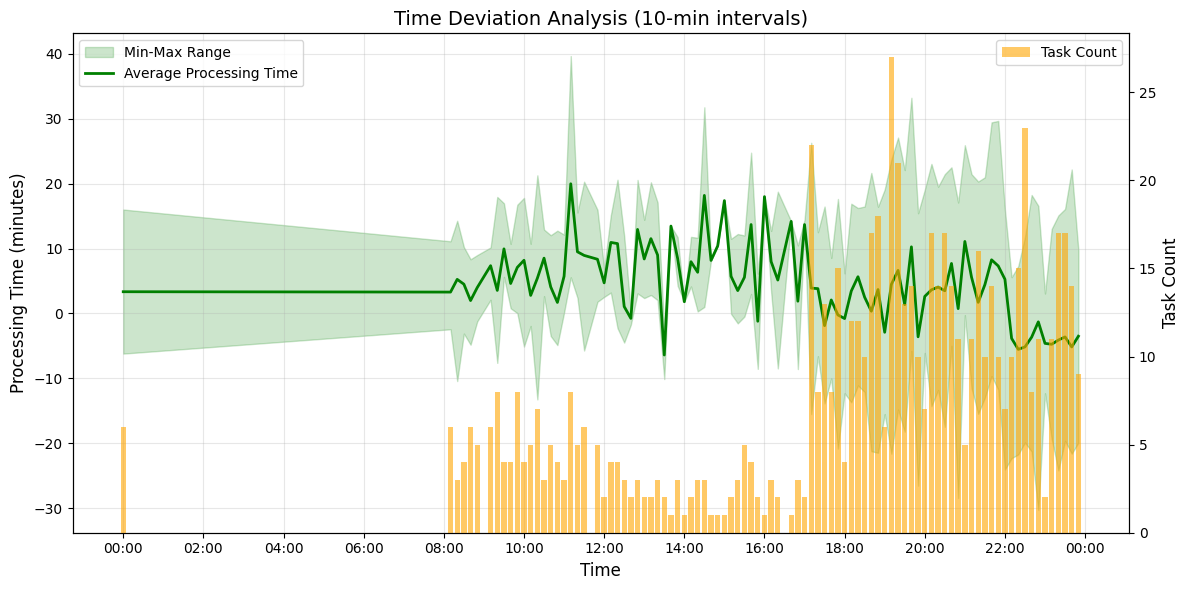


=== Summary Statistics ===
Time periods: 93
Average processing time: 4.7 minutes
Peak task count: 27 tasks
Average tasks per period: 7.6 tasks


,mean,min,max,count
start_time,,,,
2025-11-01 00:00:00,201.225000,-370.90,961.25,6
2025-11-01 08:10:00,198.008333,-146.10,667.85,6
2025-11-01 08:20:00,315.433333,-625.05,857.35,3
2025-11-01 08:30:00,271.000000,-186.20,613.95,4
2025-11-01 08:40:00,119.491667,-288.75,501.25,6
...,...,...,...,...
2025-11-01 23:10:00,-284.595455,-1160.00,781.85,11
2025-11-01 23:20:00,-246.035294,-1451.35,906.15,17
2025-11-01 23:30:00,-216.632353,-1177.40,966.35,17


In [5]:
# Fair Strategy - Time Deviation Analysis
p.deviation_in_time_taken()

=== Task Processing Time Analysis ===
Input data points: 706
Valid data points for analysis: 706


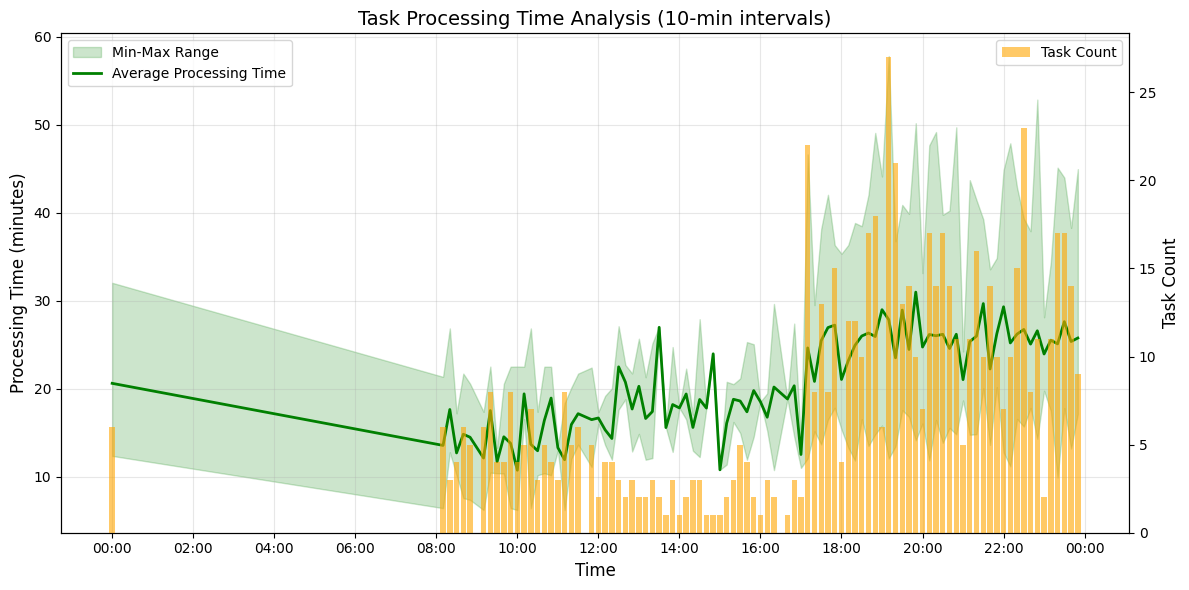


=== Summary Statistics ===
Time periods: 93
Average processing time: 20.7 minutes
Peak task count: 27 tasks
Average tasks per period: 7.6 tasks


,mean,min,max,count
start_time,,,,
2025-11-01 00:00:00,1235.666667,741.0,1921.0,6
2025-11-01 08:10:00,812.500000,385.0,1280.0,6
2025-11-01 08:20:00,1057.333333,766.0,1610.0,3
2025-11-01 08:30:00,761.250000,609.0,1031.0,4
2025-11-01 08:40:00,888.500000,454.0,1302.0,6
...,...,...,...,...
2025-11-01 23:10:00,1529.909091,1047.0,2061.0,11
2025-11-01 23:20:00,1504.823529,594.0,2706.0,17
2025-11-01 23:30:00,1656.176471,1067.0,2638.0,17


In [6]:
# Fair Strategy - Task Processing Times
p.task_processing_times()

Expected time data points: 706
=== Task Processing Time Analysis ===
Input data points: 706
Valid data points for analysis: 706


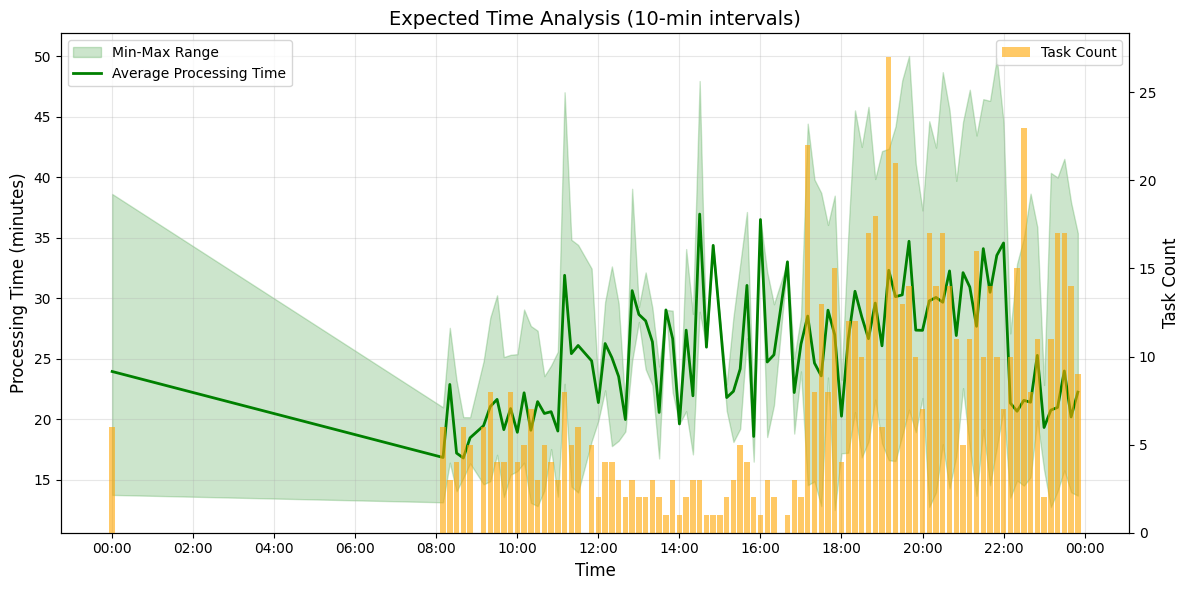


=== Summary Statistics ===
Time periods: 93
Average processing time: 25.5 minutes
Peak task count: 27 tasks
Average tasks per period: 7.6 tasks


,mean,min,max,count
start_time,,,,
2025-11-01 00:00:00,1436.891667,824.90,2317.25,6
2025-11-01 08:10:00,1010.508333,788.20,1259.15,6
2025-11-01 08:20:00,1372.766667,984.95,1653.35,3
2025-11-01 08:30:00,1032.250000,842.80,1391.95,4
2025-11-01 08:40:00,1007.991667,908.90,1210.45,6
...,...,...,...,...
2025-11-01 23:10:00,1245.313636,764.50,2421.85,11
2025-11-01 23:20:00,1258.788235,842.65,2399.15,17
2025-11-01 23:30:00,1439.544118,946.80,2491.35,17


In [7]:
# Fair Strategy - Expected Time Analysis
p.expected_time_analysis()

## Nearest Drone Assignment Strategy - Greedy Distance-Based Algorithm

### Algorithm Type: **Greedy Nearest Neighbor Assignment**

The Nearest Drone Assignment Strategy implements a **Distance-Based Greedy Algorithm** that assigns each task to the closest available drone based on geographical proximity to the task's origin point.

### How it works:
1. **Distance Calculation**: For each incoming task, calculate the distance from `task.origin` to all available drones
2. **Greedy Selection**: Select the drone with the minimum distance to the task's pickup location
3. **Immediate Assignment**: Assign the task to the nearest drone without considering global optimization
4. **Real-time Processing**: Tasks are processed as they arrive in the system

### Key Characteristics:

**Efficiency**: 
- Minimizes travel distance for pickup operations
- Reduces fuel consumption and delivery time
- Optimal for immediate response scenarios

**Simplicity**: 
- Straightforward distance-based decision making
- O(n) time complexity where n = number of available drones
- Easy to understand and implement

**Locality**: 
- Prioritizes geographical proximity
- Natural clustering of drone operations
- Efficient use of local drone resources

### Algorithm Steps:
1. Receive a new delivery task
2. Calculate distance from `task.origin` to each available drone's current position
3. Find the drone with minimum distance: `min(distance(drone.position, task.origin))`
4. Assign the task to the nearest drone if it has capacity
5. If nearest drone is full, try the next nearest drone
6. Repeat for all incoming tasks

### Use Cases:
- **Time-critical deliveries** where pickup speed is essential
- **Fuel-efficient operations** to minimize operational costs
- **Urban delivery services** with high task density
- **Emergency response** scenarios requiring immediate dispatch
- **Resource optimization** based on geographical distribution

### Trade-offs:
**Advantages:**
- Minimizes travel time and distance
- Reduces operational costs (fuel, battery)
- Simple and intuitive decision making
- Good performance for locally clustered tasks

**Disadvantages:**
- May create uneven workload distribution among drones
- Can lead to some drones being overworked while others are idle
- Doesn't consider future task arrivals or global optimization
- May not be optimal for long-term system efficiency

### Mathematical Foundation:
```
For task T with origin O, select drone D where:
D* = argmin(distance(D.position, T.origin)) for all available drones D
```

This algorithm is ideal when **minimizing delivery response time** and **operational costs** are more important than ensuring perfectly balanced workload distribution among the drone fleet.

In [8]:
class NearestDroneAssignmentStrategy(DroneAssignmentsProblemSimulator):
    """Nearest Drone Assignment Strategy implementing Greedy Distance-Based Algorithm.
    Assigns each task to the closest available drone based on geographical proximity.
    """

    def __init__(self, drone_count: int = 50):
        super().__init__(drone_count)

    def sim_update(self, dt, now):
        """Update the simulation state by assigning tasks to nearest available drones."""
        for task in self.get_pending_tasks():
            # Find the nearest available drone to the task's origin
            nearest_drone = self._find_nearest_drone(task)

            if nearest_drone is not None:
                # Try to assign the task to the nearest drone
                if not nearest_drone.assign(task):
                    # If nearest drone is full, try other drones in order of distance
                    self._assign_to_alternative_drone(task)

    def _find_nearest_drone(self, task: DeliveryTask):
        """Find the drone with minimum distance to the task's origin."""
        # Only consider operational drones (not full and has battery)
        available_drones = [drone for drone in self.get_vehicles() if drone.is_operational()]

        if not available_drones:
            return None

        # Calculate distances and find the nearest drone
        min_distance = None
        nearest_drone = None

        for drone in available_drones:
            distance = drone.position.distance_to(task.origin)
            if min_distance is None or distance < min_distance:
                min_distance = distance
                nearest_drone = drone

        return nearest_drone

    def _assign_to_alternative_drone(self, task: DeliveryTask):
        """Try to assign task to alternative drones if nearest is unavailable."""
        # Get all operational drones sorted by distance to task origin
        available_drones = [drone for drone in self.get_vehicles() if drone.is_operational()]
        drone_distances = []

        for drone in available_drones:
            distance = drone.position.distance_to(task.origin)
            drone_distances.append((drone, distance))

        # Sort by distance (ascending) - using float conversion for sorting
        drone_distances.sort(key=lambda x: float(x[1]))

        # Try to assign to drones in order of proximity
        for drone, _ in drone_distances:
            if drone.assign(task):
                break  # Successfully assigned

    def sim_post_update(self, dt, now):
        """Perform any necessary operations after the simulation update."""
        pass

In [9]:
# Run Nearest Drone Assignment Strategy simulation
nearest_sim = NearestDroneAssignmentStrategy(100)
nearest_sim.run("./test.csv", lambda task: task.order_time, j = 1, batch_size=100)
p_nearest = SimPlot(nearest_sim, "./sample_submission.csv")

Output()

╭──────────────────────────────────────────────── Current States ─────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task - ASSIGNED:                0                                                                              │
│  Task - GO_PICKUP:               0                                                                              │
│  Task - SERVICE_PICKUP:          0                                                                              │
│  Task - GO_DROPOFF:              0                                                                              │
│  Task - SERVICE_DROPOFF:         0                                                                              │
│  Task - DONE:                    706                                                                            │
│  Task - ABORTED:                 0                                                                              │
│  Vehicle - GROUNDED:             100                                                                            │
│  Vehicle - TAKING_OFF:           0                                                                              │
│  Vehicle - NAVIGATING:           0                                                                              │
│  Vehicle - LANDING:              0                                                                              │
│  Vehicle - EMERGENCY:            0                                                                              │
│  Average Task Time:              00:43:57.939                                                                   │
│  Task Time Standard Deviation:   00:28:25.105                                                                   │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Total simulation tasks: 706
Matched tasks: 706
Valid data points: 706
=== Task Processing Time Analysis ===
Input data points: 706
Valid data points for analysis: 706


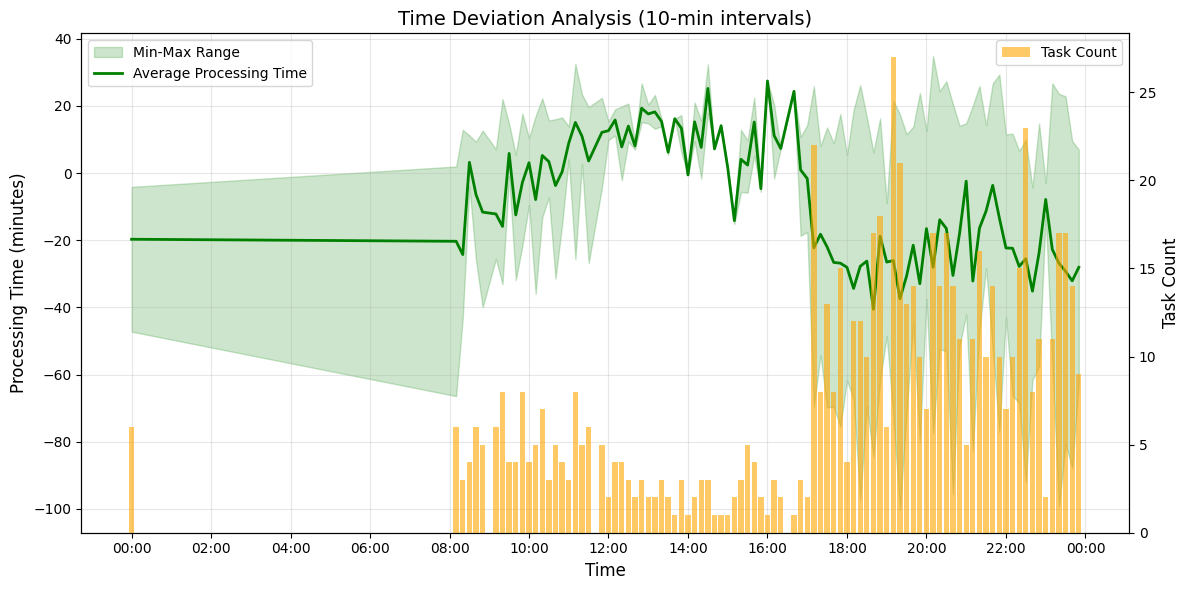


=== Summary Statistics ===
Time periods: 93
Average processing time: -7.8 minutes
Peak task count: 27 tasks
Average tasks per period: 7.6 tasks


,mean,min,max,count
start_time,,,,
2025-11-01 00:00:00,-1181.775000,-2832.90,-245.95,6
2025-11-01 08:10:00,-1217.991667,-3984.35,118.30,6
2025-11-01 08:20:00,-1454.900000,-2584.05,773.00,3
2025-11-01 08:30:00,193.250000,-236.20,672.95,4
2025-11-01 08:40:00,-384.675000,-1559.75,560.25,6
...,...,...,...,...
2025-11-01 23:10:00,-1364.140909,-3415.15,1602.85,11
2025-11-01 23:20:00,-1608.976471,-5960.20,1417.15,17
2025-11-01 23:30:00,-1755.632353,-4841.40,1371.35,17


In [10]:
# Nearest Strategy - Time Deviation Analysis
p_nearest.deviation_in_time_taken()

=== Task Processing Time Analysis ===
Input data points: 706
Valid data points for analysis: 706


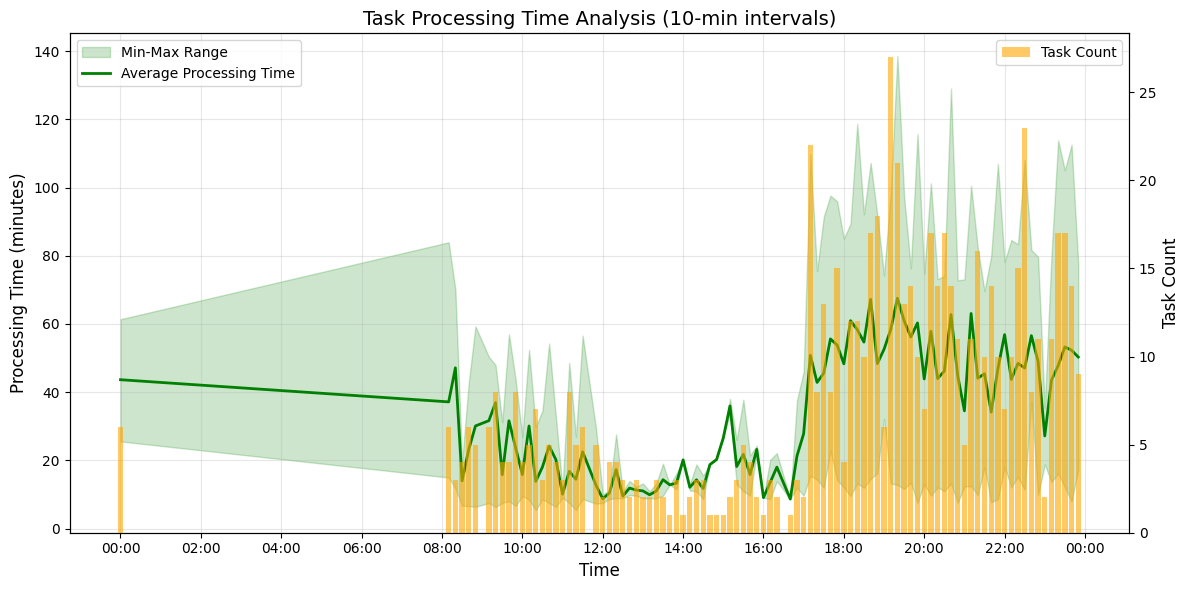


=== Summary Statistics ===
Time periods: 93
Average processing time: 33.3 minutes
Peak task count: 27 tasks
Average tasks per period: 7.6 tasks


,mean,min,max,count
start_time,,,,
2025-11-01 00:00:00,2618.666667,1533.0,3683.0,6
2025-11-01 08:10:00,2228.500000,898.0,5036.0,6
2025-11-01 08:20:00,2827.666667,707.0,4207.0,3
2025-11-01 08:30:00,839.000000,401.0,1157.0,4
2025-11-01 08:40:00,1392.666667,395.0,2571.0,6
...,...,...,...,...
2025-11-01 23:10:00,2609.454545,819.0,4806.0,11
2025-11-01 23:20:00,2867.764706,971.0,6829.0,17
2025-11-01 23:30:00,3195.176471,725.0,6302.0,17


In [11]:
# Nearest Strategy - Task Processing Times
p_nearest.task_processing_times()

Expected time data points: 706
=== Task Processing Time Analysis ===
Input data points: 706
Valid data points for analysis: 706


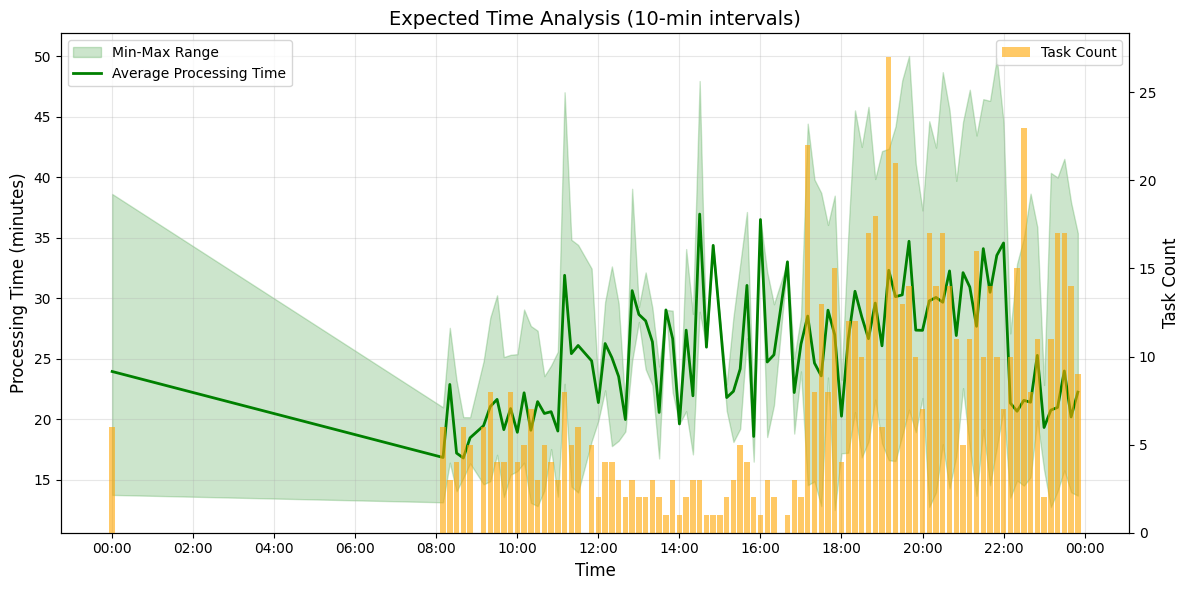


=== Summary Statistics ===
Time periods: 93
Average processing time: 25.5 minutes
Peak task count: 27 tasks
Average tasks per period: 7.6 tasks


,mean,min,max,count
start_time,,,,
2025-11-01 00:00:00,1436.891667,824.90,2317.25,6
2025-11-01 08:10:00,1010.508333,788.20,1259.15,6
2025-11-01 08:20:00,1372.766667,984.95,1653.35,3
2025-11-01 08:30:00,1032.250000,842.80,1391.95,4
2025-11-01 08:40:00,1007.991667,908.90,1210.45,6
...,...,...,...,...
2025-11-01 23:10:00,1245.313636,764.50,2421.85,11
2025-11-01 23:20:00,1258.788235,842.65,2399.15,17
2025-11-01 23:30:00,1439.544118,946.80,2491.35,17


In [12]:
# Nearest Strategy - Expected Time Analysis
p_nearest.expected_time_analysis()

## Optimal Distance Assignment Strategy - Smart Route Optimization Algorithm

### Algorithm Type: **Dynamic Route Optimization with Total Distance Minimization**

The Optimal Distance Assignment Strategy implements a **Smart Route Optimization Algorithm** that considers not only the distance to the new task's pickup location, but also the total additional travel distance when the new task is integrated into each drone's existing task queue.

### How it works:
1. **Queue Analysis**: For each drone, analyze its current task queue and planned route
2. **Route Integration**: Calculate the optimal insertion point for the new task in each drone's route
3. **Distance Calculation**: Compute the total additional distance required when inserting the new task
4. **Optimal Selection**: Choose the drone that results in the minimum total additional travel distance
5. **Dynamic Insertion**: Insert the task at the optimal position in the selected drone's queue

### Key Characteristics:

**Intelligence**: 
- Considers existing workload and routing context
- Optimizes for total system efficiency rather than just proximity
- Dynamically adapts to current operational state

**Efficiency**: 
- Minimizes total fleet travel distance
- Reduces overall fuel consumption and delivery time
- Optimizes resource utilization across the entire system

**Adaptability**: 
- Adjusts decisions based on real-time drone states
- Considers current task queues and planned routes
- Responds to varying operational conditions

### Algorithm Steps:
1. Receive a new delivery task T
2. For each operational drone D:
   - Get current task queue: [T₁, T₂, ..., Tₙ]
   - Calculate current planned route distance: `route_distance(current_queue)`
   - For each possible insertion position i (0 to n+1):
     - Create new queue: [T₁, ..., Tᵢ, T, Tᵢ₊₁, ..., Tₙ]
     - Calculate new route distance: `route_distance(new_queue)`
     - Compute additional distance: `additional_distance = new_route - current_route`
   - Record minimum additional distance for drone D
3. Select drone with minimum additional distance: `D* = argmin(additional_distance(D, T))`
4. Insert task T at the optimal position in D*'s queue

### Use Cases:
- **Fleet optimization** where total operational cost is critical
- **High-density delivery services** with multiple concurrent tasks per drone
- **Resource-constrained environments** where efficiency is paramount
- **Complex urban delivery networks** with varying distances and traffic patterns
- **Long-term operational optimization** focusing on system-wide performance

### Mathematical Foundation:
```
For task T and drone D with current queue Q = [T₁, T₂, ..., Tₙ]:

Current route distance:
R(Q) = distance(drone_pos, T₁) + Σ(distance(Tᵢ.destination, Tᵢ₊₁.origin)) + distance(Tₙ.destination, drone_pos)

For insertion at position i:
Q' = [T₁, ..., Tᵢ, T, Tᵢ₊₁, ..., Tₙ]
Additional distance = R(Q') - R(Q)

Optimal assignment:
D* = argmin(min_insertion_position(additional_distance(D, T))) for all drones D
```

### Trade-offs:
**Advantages:**
- Globally optimized route planning
- Minimizes total system operational costs
- Considers real-time operational context
- Better long-term efficiency than greedy approaches
- Intelligent task queue management

**Disadvantages:**
- Higher computational complexity O(n×m×k) where n=drones, m=avg_queue_size, k=insertion_positions
- More complex implementation and debugging
- May have longer initial response times due to optimization calculations
- Requires maintaining detailed state information for all drones

### Comparison with Other Strategies:

**vs Fair Assignment:**
- More efficient but potentially less balanced workload
- Considers route optimization vs simple round-robin

**vs Nearest Assignment:**
- More intelligent but computationally more expensive
- Considers entire route context vs just pickup proximity

**vs All Strategies:**
- Highest optimization potential for total system efficiency
- Best suited for scenarios where operational cost minimization is the primary goal

This algorithm is ideal when **minimizing total operational costs** and **maximizing system-wide efficiency** are more important than simplicity or guaranteed workload balance. It's particularly effective in scenarios with high task density and complex routing requirements.

In [13]:
class OptimalDistanceAssignmentStrategy(DroneAssignmentsProblemSimulator):
    """Nearest Drone Assignment Strategy implementing Greedy Distance-Based Algorithm.
    Assigns each task to the closest available drone based on geographical proximity.
    """

    def __init__(self, drone_count: int = 50):
        super().__init__(drone_count)

    def sim_update(self, dt, now):
        """Update the simulation state by assigning tasks to nearest available drones."""
        for task in self.get_pending_tasks():
            # Find the nearest available drone to the task's origin
            optimal_drone = self._find_optimal_drone(task)

            if optimal_drone is not None:
                # Try to assign the task to the nearest drone
                if not optimal_drone.assign(task):
                    # If nearest drone is full, try other drones in order of distance
                    self._assign_to_alternative_drone(task)

    def _find_optimal_drone(self, task: DeliveryTask):
        """Find the drone with minimum distance to the task's origin."""
        # Only consider operational drones (not full and has battery)
        available_drones = [drone for drone in self.get_vehicles() if drone.is_operational()]

        if not available_drones:
            return None

        # Calculate distances and find the nearest drone
        min_distance = None
        nearest_drone = None

        for drone in available_drones:
            distance, last_point = drone.route_remainder
            distance += last_point.distance_to(task.origin)
            if min_distance is None or distance < min_distance:
                min_distance = distance
                nearest_drone = drone

        return nearest_drone

    def _assign_to_alternative_drone(self, task: DeliveryTask):
        """Try to assign task to alternative drones if nearest is unavailable."""
        # Get all operational drones sorted by distance to task origin
        available_drones = [drone for drone in self.get_vehicles() if drone.is_operational()]
        drone_distances = []

        for drone in available_drones:
            distance, last_point = drone.route_remainder
            distance += last_point.distance_to(task.origin)
            drone_distances.append((drone, distance))

        # Sort by distance (ascending) - using float conversion for sorting
        drone_distances.sort(key=lambda x: float(x[1]))

        # Try to assign to drones in order of proximity
        for drone, _ in drone_distances:
            if drone.assign(task):
                break  # Successfully assigned

    def sim_post_update(self, dt, now):
        """Perform any necessary operations after the simulation update."""
        pass

In [14]:
# Run Optimal Distance Assignment Strategy simulation
optimal_sim = OptimalDistanceAssignmentStrategy(100)
optimal_sim.run("./test.csv", lambda task: task.order_time, j = 1, batch_size=100)
p_optimal = SimPlot(optimal_sim, "./Sample_Submission.csv")

Output()

╭──────────────────────────────────────────────── Current States ─────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task - ASSIGNED:                0                                                                              │
│  Task - GO_PICKUP:               0                                                                              │
│  Task - SERVICE_PICKUP:          0                                                                              │
│  Task - GO_DROPOFF:              0                                                                              │
│  Task - SERVICE_DROPOFF:         0                                                                              │
│  Task - DONE:                    706                                                                            │
│  Task - ABORTED:                 0                                                                              │
│  Vehicle - GROUNDED:             100                                                                            │
│  Vehicle - TAKING_OFF:           0                                                                              │
│  Vehicle - NAVIGATING:           0                                                                              │
│  Vehicle - LANDING:              0                                                                              │
│  Vehicle - EMERGENCY:            0                                                                              │
│  Average Task Time:              00:20:38.544                                                                   │
│  Task Time Standard Deviation:   00:09:27.774                                                                   │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Total simulation tasks: 706
Matched tasks: 706
Valid data points: 706
=== Task Processing Time Analysis ===
Input data points: 706
Valid data points for analysis: 706


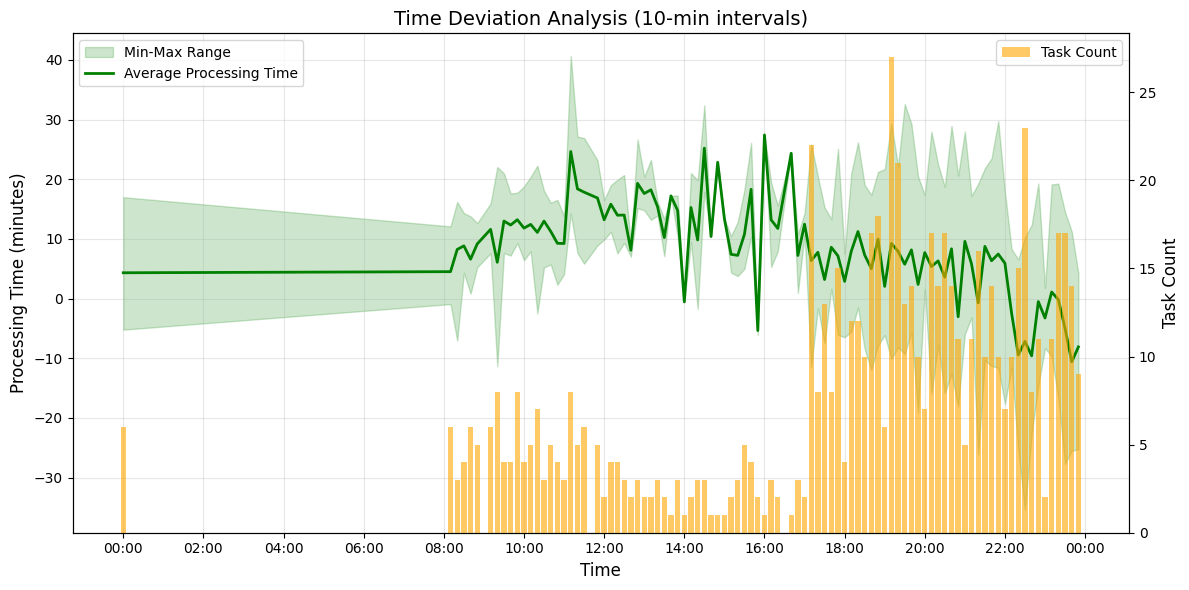


=== Summary Statistics ===
Time periods: 93
Average processing time: 8.5 minutes
Peak task count: 27 tasks
Average tasks per period: 7.6 tasks


,mean,min,max,count
start_time,,,,
2025-11-01 00:00:00,260.225000,-311.90,1020.25,6
2025-11-01 08:10:00,271.341667,-55.10,726.85,6
2025-11-01 08:20:00,494.766667,-422.05,972.35,3
2025-11-01 08:30:00,530.750000,259.80,859.95,4
2025-11-01 08:40:00,396.658333,49.85,827.45,6
...,...,...,...,...
2025-11-01 23:10:00,66.768182,-580.50,1148.85,11
2025-11-01 23:20:00,-9.858824,-1000.55,1156.15,17
2025-11-01 23:30:00,-298.102941,-1661.40,870.35,17


In [15]:
# Optimal Strategy - Time Deviation Analysis
p_optimal.deviation_in_time_taken()

=== Task Processing Time Analysis ===
Input data points: 706
Valid data points for analysis: 706


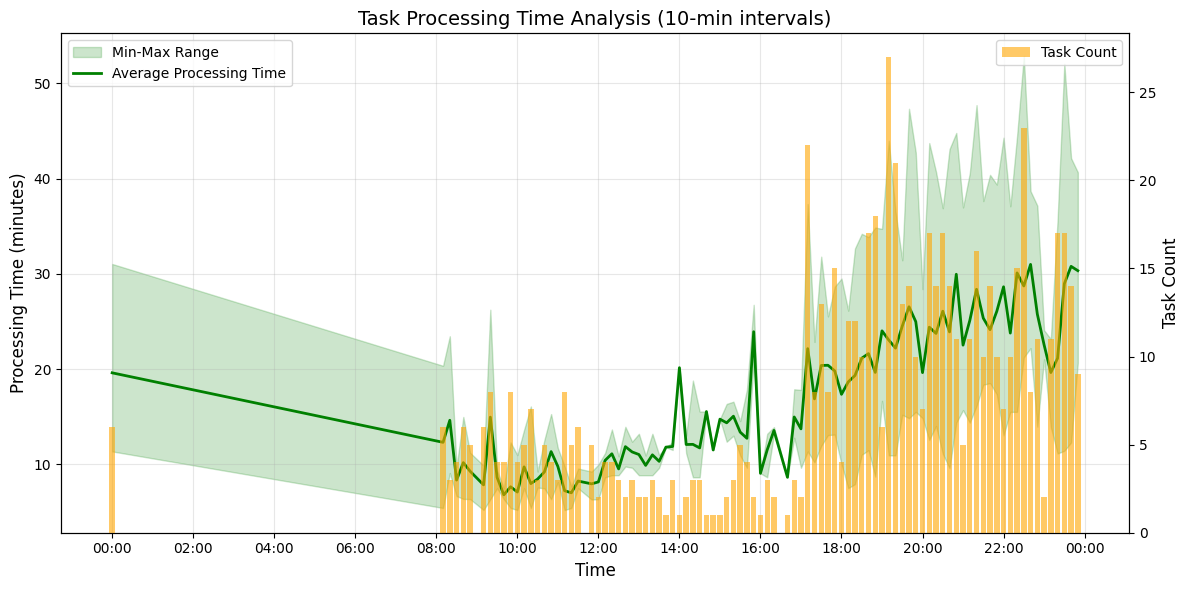


=== Summary Statistics ===
Time periods: 93
Average processing time: 16.9 minutes
Peak task count: 27 tasks
Average tasks per period: 7.6 tasks


,mean,min,max,count
start_time,,,,
2025-11-01 00:00:00,1176.666667,682.0,1862.0,6
2025-11-01 08:10:00,739.166667,326.0,1221.0,6
2025-11-01 08:20:00,878.000000,546.0,1407.0,3
2025-11-01 08:30:00,501.500000,401.0,583.0,4
2025-11-01 08:40:00,611.333333,383.0,899.0,6
...,...,...,...,...
2025-11-01 23:10:00,1178.545455,834.0,1389.0,11
2025-11-01 23:20:00,1268.647059,669.0,2137.0,17
2025-11-01 23:30:00,1737.647059,686.0,3122.0,17


In [16]:
# Optimal Strategy - Task Processing Times
p_optimal.task_processing_times()

Expected time data points: 706
=== Task Processing Time Analysis ===
Input data points: 706
Valid data points for analysis: 706


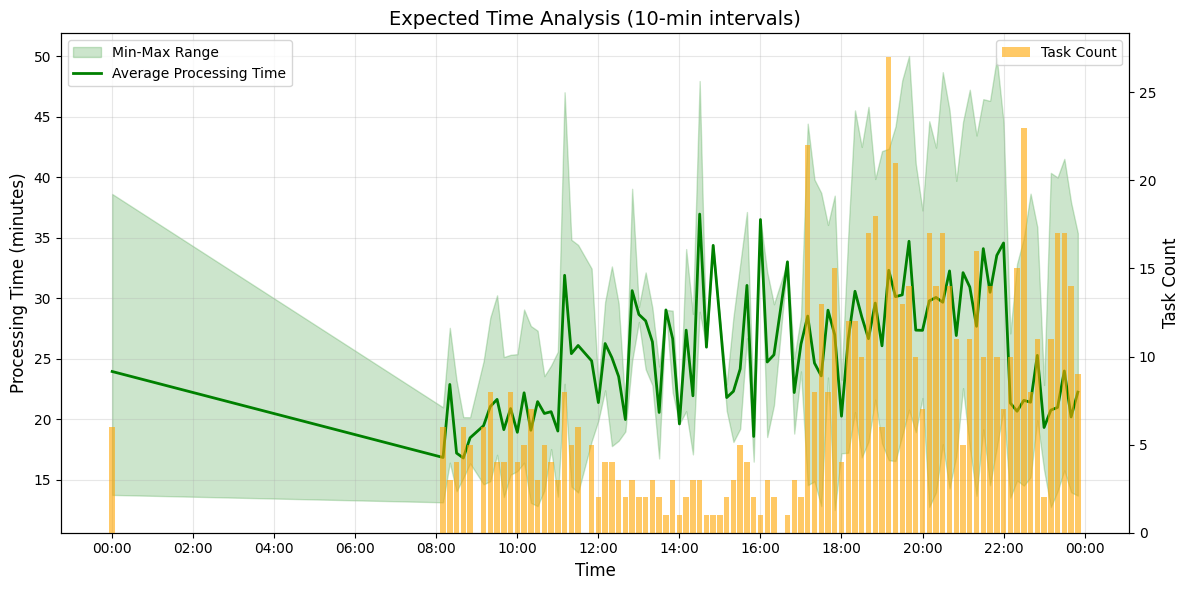


=== Summary Statistics ===
Time periods: 93
Average processing time: 25.5 minutes
Peak task count: 27 tasks
Average tasks per period: 7.6 tasks


,mean,min,max,count
start_time,,,,
2025-11-01 00:00:00,1436.891667,824.90,2317.25,6
2025-11-01 08:10:00,1010.508333,788.20,1259.15,6
2025-11-01 08:20:00,1372.766667,984.95,1653.35,3
2025-11-01 08:30:00,1032.250000,842.80,1391.95,4
2025-11-01 08:40:00,1007.991667,908.90,1210.45,6
...,...,...,...,...
2025-11-01 23:10:00,1245.313636,764.50,2421.85,11
2025-11-01 23:20:00,1258.788235,842.65,2399.15,17
2025-11-01 23:30:00,1439.544118,946.80,2491.35,17


In [17]:
# Optimal Strategy - Expected Time Analysis
p_optimal.expected_time_analysis()